# Introduction tutorial

This tutorial is an extended version of the quickstart guide in the README and explains the marginalisation script in the Jupyter notebook interface and shows some examples.

### <span style="color:red">**You can not run `Cell -> Run All` before you have set up your configfile!** </span>

We will assume that you have cloned the repo, created the conda environment from the `environment.yml` file and created your `config_local.ini` (see README).

## Input parameters

### Input and output data paths

To be able to do our example run on the provided data, you need to point the local configfile to your local repository clone:
```ini
[data_paths]
local_path = /Users/<YourUser>/repos/ExoTiC-ISM
```

To run the script on the provided example data on the repository, you can keep the default input data path in the configfile, as it points to the data directory in the respository.
```ini
[data_paths]
local_path = ..
input_path = ${local_path}/data
```

You will need to specify a location on disk for the output data:
```ini
[data_paths]
...
output_path = /Users/MyUser/outputs
```

And if you like, you can change the experiment suffix that will be attached to the filename of your output folder:
```ini
[data_paths]
...
run_name = notebook_test
```

In the end the `[data_paths]` section in the configfile should look something like this:
```ini
[data_paths]
local_path = /Users/MyUser/repos/ExoTiC-ISM
input_path = ${local_path}/data
output_path = /Users/MyUser/outputs
run_name = notebook_test
```

### <span style="color:green">**At this point, you could just run the entire notebook by clicking `Cell -> Run All`.** </span>

### General setup

For the general setup, we are interested in what instrument and grating was used to collect the data on which specific stellar system. This is done in the configfile section `[setup]`. If you're just interested in running the demo as is, you can leave all of these to their default values.

First, define what star the data is from - the example data is of WASP-17b, so we dubbed the stellar system section `W17`:
```ini
[setup]
data_set = W17
```

The instrument for this data is Wide Field Camera 3 (WFC3) and the data was taken with the IR grating G141:
```ini
[setup]
...
instrument = WFC3
grating = G141
```

You need to decide which general grid of systematic models you want to use. For WFC3, this grid consists of 50 distinct systematic models used to fit the data, in all of which the transit depth `rl` and the baseline flux `flux0` are always free parameters. The choice you have to make is which of the variable parameters **epoch**, **inclination**, **MsMpR** and **eccentricity** you want to keep fixed ("frozen") or free ("thawed"):

- `fix_time`: all of them are frozen
- `fit_time`: epoch is thawed, other three are frozen
- `fit_inclin`: inclination is thawed, other three are frozen
- `fit_msmpr`: MsMpR is thawed, other three are frozen
- `fit_ecc`: eccentricity is thawed, other three are frozen
- `fit_all`: eccentricity is frozen, other three are thawed

```ini
[setup]
...
grid_selection = fit_time
```

The repository provides a range of both 1D and 3D stellar models to calculate the limb darkening, so you need to chose which ones to use:
```ini
[setup]
...
ld_model = 3D
```

And finally, you need to decide whether you want the fit results of each systematic model to be displayed at runtime, which can be helpful for troubleshooting but also annoying when trying to work while the code is running, and whether you want the PDF report with the results to be created. It is highly recommended to always keep this `True`, we included the feature to disable this purely to be able to skip this step if the required python packages for this are not available for any reason.

```ini
[setup]
...
plotting = True
report = True
```

In the end, your general setup should look something like this:
```ini
[setup]
data_set = W17
instrument = WFC3
grating = G141
grid_selection = fit_time
ld_model = 3D
plotting = True
report = True
```

### Smooth model parameters

At convenient points in the code, the marginalisation script will calculate a smooth model of the fit. The following configfile section defines at what resolution it gets calculated and what its range in terms of planet phase it will encapsulate. You might need to adjust especially the `half_range` if your data has a significantly different transit length than the example data. For `W17` we use:

```ini
[smooth_model]
resolution = 0.0001
half_range = 0.2
```

### Stellar and planetary system parameters

The last important bit is to define the input parameters for the star and planet. For each new data set you want to analyse, you need to create a new section in your configfile that carries the same section name like what you put in the `data_set` name in `[section] -> data_set`. For the example data, we have a section called `[W17]` that holds all stellar parameters (for the limb darkening calculation) and the initial guesses for the fitting parameters for the planetary transit.

```ini
[W17]
...
rl = 0.12169232
epoch = 57957.970153390
inclin = 87.34635
ecc = 0.0
omega = 0.0
Per = 3.73548535
aor = 7.0780354

; limb darkening parameters
metallicity = -1.0
Teff = 6550
logg = 4.5
```

At the top of this section is where you drop in the file names of your data files - one lightcurve file and one file with a wavelength array. If you have more than one data set available for a specific system, your filenames should indicate by what they differ, e.g. different gratings (e.g. G141 or G102), so that you have to make only one single change in your configfile when your changing from one data set to the other. For example, if you have W17 data both with the G141 as well as the G102 grating, you can include the grating name in the filenames and adjust them in the configfile in such a way that the correct files get picked when you adjust your grating of choice in `[setup] -> grating`.

```ini
[setup]
...
grating = G141
...

[W17]
lightcurve_file = W17_${setup:grating}_lightcurve_test_data.txt
wvln_file = W17_${setup:grating}_wavelength_test_data.txt
```

which represents these data files:  
```bash
W17_G141_lightcurve_test_data.txt
W17_G141_wavelength_test_data.txt
```

## Fitting with Sherpa

Before turning to the marginalisation, let us have a look at how the fitting is performed. We use a package called [sherpa](https://sherpa.readthedocs.io/en/latest/). `Sherpa` allows you to write your own model that subsequently gets fit to your data with a **statistic** and an **optimizer** of your choice. ExoTiC-ISM uses the **chi-squared** statistic and the **Levenberg-Marquardt** optimizer, which you can read more about in [Wakeford et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...819...10W/abstract) and in the `sherpa` documentation, as well as in any standard sources for least-squares optimisations.

We have transfered our transit model, which is the analytic transit model from [Mandel & Agol (2002)](https://ui.adsabs.harvard.edu/abs/2002ApJ...580L.171M/abstract), into the `sherpa` model format. To make sure this works, we can instantiate a simple transit model based on a simple data set that we will create here.

Just as for a real data set, we created a configfile section for our custom transit, containing the initial guess for the fitting parameters as well as the stellar parameters needed to calculate the limb darkening.

```ini
[simple_transit]
rl = 0.1
epoch = 0.
inclin = 90
ecc = 0.0
omega = 0.0
Per = 3.5
aor = 7.0

; limb darkening parameters
metallicity = 0.0
Teff = 5500
logg = 4.5
```

In [4]:
# First some imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import G

import exoticism.margmodule as marg
from exoticism.config import CONFIG_INI
repo_dir = CONFIG_INI.get('data_paths', 'local_path')
print(repo_dir)

/Users/ilaginja/repos/ExoTiC-ISM


In [2]:
# Create simple phase array, grouped in three observation sets to replicate HST orbits
data_x = np.array([-0.046, -0.044, -0.042, -0.040, -0.038, -0.036, -0.034,
                   -0.032, -0.030, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004,
                   0.006, 0.008, 0.01, 0.032, 0.034, 0.036, 0.038, 0.040,
                   0.042, 0.044, 0.046,0.048])

# Create simple light curve
data_y = np.array([0.99908000, 0.99912000, 0.99915999, 0.99919999, 0.99923998, 
                   0.99927998, 0.99931997, 0.99936002, 0.99940002, 0.98886081, 
                   0.98884753, 0.98885626, 0.98888551, 0.98893542, 0.98900574, 
                   0.98909820, 0.98921506, 0.98936069, 1.0006400, 1.0006800, 1.0007200, 
                   1.0007600, 1.0008000, 1.0008399, 1.0008800, 1.0009201, 1.0009600])

# Assume each data point has exactly the same uncertainty (error)
uncertainty = np.array([0.0003] * len(data_y))

# Add random scatter to the light curve
random_scatter = np.array([1.1538402,-0.10449710,1.2461015,0.36272651,0.19734389,-0.47116757,
                           0.40506387,-0.35902504,-1.3339216,1.1573253,-0.86973712,-1.3806844,
                           -0.074376698,-0.49212716,-0.032587608,-0.25996890,-0.11661747,
                           0.18881522,-0.49201830,0.53960426,2.8065479,-1.2256125,-1.2761705,
                           0.82821630,-0.97344185,1.2205489,-0.69391900])

data_y += random_scatter * uncertainty

We can have a quick look at our created data with `matplotlib`:

Text(0, 0.5, 'Flux')

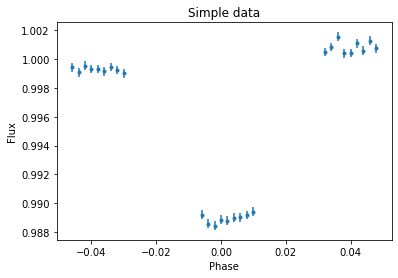

In [3]:
plt.title('Simple data')
plt.errorbar(data_x, data_y, yerr=uncertainty, fmt='.')
plt.xlabel('Phase')
plt.ylabel('Flux')

To be able to use `sherpa`, we need to create a `sherpa` **data object** from our simple data, which has its own methods to plot the data. This is exactly the same data, we are just showing a different way to plot it. 

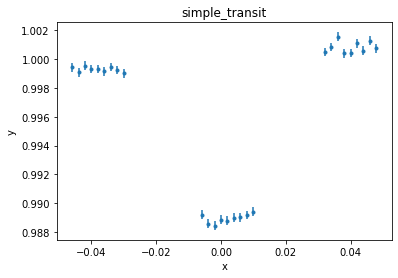

In [4]:
from sherpa.data import Data1D
from sherpa.plot import DataPlot

data = Data1D('simple_transit', data_x, data_y, staterror=uncertainty)   # create data object
dplot = DataPlot()         # create data *plot* object
dplot.prepare(data)       # prepare plot
dplot.plot()

In order to instantiate the transit model, we need to read some of the parameters from the configfile.

In [5]:
# Simple transit parameters
planet_sys = CONFIG_INI.get('setup', 'data_set')
dtosec = CONFIG_INI.getfloat('constants', 'dtosec')
period = CONFIG_INI.getfloat(planet_sys, 'Per')
Per = period * dtosec
aor = CONFIG_INI.getfloat(planet_sys, 'aor')
constant1 = (G * Per * Per / (4 *np.pi * np.pi))**(1/3)
msmpr = (aor/(constant1))**3

print('msmpr: {}'.format(msmpr))
print('G: {}'.format(G.value))
print('Per: {} sec'.format(Per))

msmpr: 2013.6545130315214 kg s2 / m3
G: 6.67408e-11
Per: 322745.93424 sec


In this example, we will provide limb darkening coefficients that make sense. In the main marginalisation script, these get calculated based on the configfile inputs for the stellar parameters and the choice of models.

In [6]:
# Limb darkening coefficients
c1s = 0.66396105
c2s = -0.12617095
c3s = 0.053649047
c4s = -0.026713433

Now we can go ahead and instantiate a transit **model object** with our inputs.

In [7]:
model = marg.Transit(data_x[0], msmpr, c1s, c2s, c3s, c4s, flux0=data_y[0],
                     x_in_phase=True, name='transit_model', sh=None)

We can easily check which fitting parameters are currently thawed and which are frozen, and what their initial guesses are.

In [8]:
print(model)

transit_model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   transit_model.rl thawed     0.121692 -3.40282e+38  3.40282e+38           
   transit_model.flux0 thawed     0.999426 -3.40282e+38  3.40282e+38           
   transit_model.epoch thawed        57958 -3.40282e+38  3.40282e+38 days [MJD]
   transit_model.inclin thawed      1.52448 -3.40282e+38  3.40282e+38    radians
   transit_model.msmpr thawed      2013.65 -3.40282e+38  3.40282e+38           
   transit_model.ecc thawed            0 -3.40282e+38  3.40282e+38    degrees
   transit_model.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   transit_model.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   transit_model.tzero frozen       -0.046 -3.40282e+38  3.40282e+38 days [MJD]
   transit_model.c1 frozen     0.663961 -3.40282e+38  3.40282e+38           
   transit_model.c2 frozen    -0.126171 -3.402

To keep things simple, we will freeze almost all parameters except for the tranist depth `rl` and the baseline flux `flux0`.

In [9]:
# Freese almost all parameters
model.epoch.freeze()
model.inclin.freeze()
model.msmpr.freeze()
model.ecc.freeze()
model.m_fac.freeze()
model.hstp1.freeze()
model.hstp2.freeze()
model.hstp3.freeze()
model.hstp4.freeze()
model.xshift1.freeze()
model.xshift2.freeze()
model.xshift3.freeze()
model.xshift4.freeze()

print(model)

transit_model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   transit_model.rl thawed     0.121692 -3.40282e+38  3.40282e+38           
   transit_model.flux0 thawed     0.999426 -3.40282e+38  3.40282e+38           
   transit_model.epoch frozen        57958 -3.40282e+38  3.40282e+38 days [MJD]
   transit_model.inclin frozen      1.52448 -3.40282e+38  3.40282e+38    radians
   transit_model.msmpr frozen      2013.65 -3.40282e+38  3.40282e+38           
   transit_model.ecc frozen            0 -3.40282e+38  3.40282e+38    degrees
   transit_model.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   transit_model.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   transit_model.tzero frozen       -0.046 -3.40282e+38  3.40282e+38 days [MJD]
   transit_model.c1 frozen     0.663961 -3.40282e+38  3.40282e+38           
   transit_model.c2 frozen    -0.126171 -3.402

In order to visualize the model, we need to calculate it on a grid of x-values. To do so, will will create a smooth and uniform x-array.

In [10]:
x_smooth = np.arange(data_x[0], data_x[-1], CONFIG_INI.getfloat('smooth_model', 'resolution'))

We can now calculate the model on this smooth grid.

In [11]:
# First dump all model parameters into tuple to access them easier
# (there is an easier way for this which we will implement at a later point)
params = (model.rl.val, model.flux0.val, model.epoch.val, model.inclin.val, model.MsMpR.val,
          model.ecc.val, model.omega.val, model.period.val, model.tzero.val, model.c1.val,
          model.c2.val, model.c3.val, model.c4.val, model.m_fac.val, model.hstp1.val,
          model.hstp2.val, model.hstp3.val, model.hstp4.val, model.xshift1.val,
          model.xshift2.val, model.xshift3.val, model.xshift4.val)

# Calculate model on denser grid to display
y_smooth_model = model.calc(pars=params, x=x_smooth)

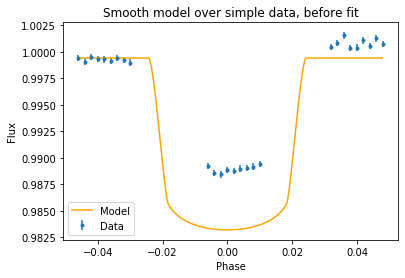

In [12]:
# And display that
plt.plot(x_smooth, y_smooth_model, c='orange', label='Model')
plt.errorbar(data_x, data_y, yerr=uncertainty, fmt='.', label='Data')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Smooth model over simple data, before fit')
plt.legend()

We can clearly see how the current model parameters (yellow curve) are not a good fit to the data (blue dots); especially the transit depth is way off. In order to make this better, we will now chose our **statistic** and an **optimizer**, and perform a fit.

Same as in the marginalisation script, we will chose the chi-squared statistic and an LM optimizer.

In [13]:
from sherpa.optmethods import LevMar
from sherpa.stats import Chi2

# Set up the statistic and optimizer
stat = Chi2()
opt = LevMar()
opt.config['epsfcn'] = np.finfo(float).eps   # adjusting epsfcn to double precision

print(stat)
print(opt)

Chi Squared statistic.

    The chi-square statistic is:

        chi^2 = (sum)_i [ [ N(i,S) - B(i,x,pB) - S(i,x,pS) ]^2 / sigma(i)^2 ]

    where N(i,S) is the total number of observed counts in bin i of
    the on-source region; B(i,x,pB) is the number of predicted
    background model counts in bin i of the on-source region (zero for
    background-subtracted data), rescaled from bin i of the off-source
    region, and computed as a function of the model argument x(i)
    (e.g., energy or time) and set of background model parameter
    values pB; S(i,x,pS) is the number of predicted source model
    counts in bin i, as a function of the model argument x(i) and set
    of source model parameter values pS; and sigma(i) is the error in
    bin i.

    N(i,B) is the total number of observed counts in bin i of the
    off-source region; A(B) is the off-source "area", which could be
    the size of the region from which the background is extracted, or
    the length of a background time s

So far, we have defined a data object and put that into a model object. We have settled on a statistic and an optimizer, so now we will combine the statistic and optimizer with the data and model to instantiate a **fit object**.

In [14]:
from sherpa.fit import Fit

tfit = Fit(data, model, stat=stat, method=opt)
print(tfit)

data      = simple_transit
model     = transit_model
stat      = Chi2
method    = LevMar
estmethod = Covariance


What is left to do is to perform the fit and check the results.

In [15]:
fitresult = tfit.fit()
print(fitresult)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('transit_model.rl', 'transit_model.flux0')
parvals        = (0.10088927464967297, 1.000051154533817)
statval        = 142.3602455266665
istatval       = 3403.6560212456448
dstatval       = 3261.2957757189783
numpoints      = 27
dof            = 25
qval           = 2.1278874531743445e-18
rstat          = 5.694409821066659
message        = successful termination
nfev           = 12


We can access the covariance matrix of the fit directly, from where we calculate the parameter errors.

In [16]:
hessian = np.sqrt(fitresult.extra_output['covar'].diagonal())
rl_err = hessian[0]

print('rl = {} +/- {}'.format(model.rl.val, rl_err))
print('Reduced chi-squared: {}'.format(fitresult.rstat))

rl = 0.10088927464967297 +/- 0.0005568324519543845
Reduced chi-squared: 5.694409821066659


And if we replot the new fit, we can see how this looks way better now. Here we have just fit for the depth and baseline flux so any additional structure in the data is still there, but the model now lines up nicely with the blue points. 

In [17]:
# Dump parameters in a single tuple again
params_result = (model.rl.val, model.flux0.val, model.epoch.val, model.inclin.val, model.MsMpR.val,
                 model.ecc.val, model.omega.val, model.period.val, model.tzero.val, model.c1.val,
                 model.c2.val, model.c3.val, model.c4.val, model.m_fac.val, model.hstp1.val,
                 model.hstp2.val, model.hstp3.val, model.hstp4.val, model.xshift1.val,
                 model.xshift2.val, model.xshift3.val, model.xshift4.val)

# Recalculate model on smooth grid now that we performed the fit
y_smooth_fit = model.calc(pars=params_result, x=x_smooth)

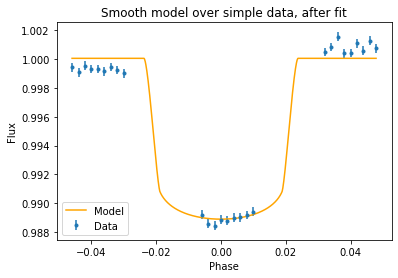

In [18]:
# Plot the fit
plt.plot(x_smooth, y_smooth_fit, c='orange', label='Model')
plt.errorbar(data_x, data_y, yerr=uncertainty, fmt='.', label='Data')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Smooth model over simple data, after fit')
plt.legend()

## Limb darkening

The limb darkening coefficients used for the fitting get calculated in the main marginalisation script, and here we will briefly look into how this is done.

First, we usually read the stellar parameters used in the calculation listed under limb darkening in the configfile. In this tutorial, we set some of them manually.

In [19]:
# Which stellar and planetary system are we working on?
exoplanet = 'simple_transit'
print('System: {}'.format(exoplanet))

# Read its limb darkening parameters
M_H = CONFIG_INI.getfloat(exoplanet, 'metallicity')    # stellar metallicity - limited ranges available
Teff = CONFIG_INI.getfloat(exoplanet, 'Teff')   # stellar temperature - for 1D models: steps of 250 starting at 3500 and ending at 6500
logg = CONFIG_INI.getfloat(exoplanet, 'logg')   # log(g), stellar gravity - depends on whether 1D or 3D limb darkening models are used
print('M_H: {}'.format(M_H))
print('Teff: {}'.format(Teff))
print('logg: {}'.format(logg))

# Define limb darkening directory, which is inside this package
# and read limb darkening model choice and grating
limbDir = os.path.join(repo_dir, 'Limb-darkening')
ld_model = '1D'
grat = 'G141'
print('LD model: {}'.format(ld_model))
print('Grating: {}'.format(grat))

System: simple_transit
M_H: 0.0
Teff: 5500.0
logg: 4.5
LD model: 1D
Grating: G141


Note how in the section `[setup]`, you can chose whether you want to use the 1D or the 3D stellar model grids for the limb darkening.

The 3D grid is more sparse than the 1D grid, you can see that by the possible values for metallicity, effective temperature and stellar gravity in the function `limb_dark_fit` in the module `limb_darkening.py`. While the 1D grid covers a wider range of physical parameters, the 3D grid takes a more detailed look at a narrower range. You can pick the one that is more appropriate for your star.

```ini
[setup]
...
ld_model = 3D
```

We can now proceed to calculate the limb darkening coefficients. To do that, we need to load the wavelength array, which we will do for W17, on whichever grid is currently picked in the configfile.  
In the main script, the four non-linear limb darkening coefficients get used: c1, c2, c3 and c4 

In [20]:
limbDir

'/Users/ilaginja/Documents/Git/ExoTiC-ISM/Limb-darkening'

In [21]:
from exoticism.limb_darkening import limb_dark_fit

# Load wavelength array
dataDir = os.path.join('data', 'W17')
get_wvln = CONFIG_INI.get('W17', 'wvln_file')
print(os.getcwd())
print(dataDir)
wavelength = np.loadtxt(os.path.join(dataDir, get_wvln), skiprows=3)

_uLD, c1, c2, c3, c4, _cp1, _cp2, _cp3, _cp4, _aLD, _bLD = limb_dark_fit(grat, wavelength, M_H, Teff,
                                                                         logg, limbDir, ld_model)

print('\nc1 = {}'.format(c1))
print('c2 = {}'.format(c2))
print('c3 = {}'.format(c3))
print('c4 = {}'.format(c4))

/Users/ilaginja/Documents/Git/ExoTiC-ISM
data/W17
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/ilaginja/Documents/Git/ExoTiC-ISM/Limb-darkening
  /Users/ilaginja/Documents/Git/ExoTiC-ISM/Limb-darkening/Kurucz

Closest values to your inputs:
Teff:  5500.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59101889	0.02400700	-0.01528649	-0.03046731
3param 	1.97902274	-2.49031207	1.02677503
Quad 	0.10041831	0.37550136
Linear 	0.41853892

c1 = 0.5910188860325543
c2 = 0.02400699950273899
c3 = -0.015286489494103744
c4 = -0.030467310672732104


## Marginalisation across a grid of systematic models

The heart of the code in this repository is the marginalisation across different systematic models and the calculation of marginalised transit parameters. We will use the simple demo data above to demonstrate how this is done.

We will assume that there are two feasible systematic models that we want to marginalise over. One is the same as above, where we allow a transit depth `rl` and the baseline flux `flux0` to vary. Since these are transit parameters and not instrument systematics, this model assumes that there is no correction for the instrument happening. The second model will also include a linear shift with the slope `m_fac`, which means that we are including a proxy for an instrument systematic. The whole parameter grid for WFC3 contains 22 parameters, which we can see from the model we created above:

In [22]:
model.pars

(<Parameter 'rl' of model 'transit_model'>,
 <Parameter 'flux0' of model 'transit_model'>,
 <Parameter 'epoch' of model 'transit_model'>,
 <Parameter 'inclin' of model 'transit_model'>,
 <Parameter 'msmpr' of model 'transit_model'>,
 <Parameter 'ecc' of model 'transit_model'>,
 <Parameter 'omega' of model 'transit_model'>,
 <Parameter 'period' of model 'transit_model'>,
 <Parameter 'tzero' of model 'transit_model'>,
 <Parameter 'c1' of model 'transit_model'>,
 <Parameter 'c2' of model 'transit_model'>,
 <Parameter 'c3' of model 'transit_model'>,
 <Parameter 'c4' of model 'transit_model'>,
 <Parameter 'm_fac' of model 'transit_model'>,
 <Parameter 'hstp1' of model 'transit_model'>,
 <Parameter 'hstp2' of model 'transit_model'>,
 <Parameter 'hstp3' of model 'transit_model'>,
 <Parameter 'hstp4' of model 'transit_model'>,
 <Parameter 'xshift1' of model 'transit_model'>,
 <Parameter 'xshift2' of model 'transit_model'>,
 <Parameter 'xshift3' of model 'transit_model'>,
 <Parameter 'xshift4' 

The grid we are constructing here for our imaginary instrument will have two rows, since we have **two systematic instrument models** (one that does not include any systematics and one that includes a linear slope), and 22 columns, since we have to tell each of the 22 parameters of the implemented transit model whether it is free to be fit (thawed) or fixed (frozen) in each of the systematic models. A `1` indicates that the parameter is frozen and a `0` indicates that it is thawed.

In [23]:
simple_systematic_model_grid = np.array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                                         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]])
print(simple_systematic_model_grid.shape)

nsys = simple_systematic_model_grid.shape[0]        # Number of systematic models
nparams = simple_systematic_model_grid.shape[1]     # Numer of parameters
nexposure = len(data_x)

(2, 22)


To have a clean slate, we will set up a new model that we will use for the marginalisation. (Technically, we don't have to do this, but we wanted to make it explicit that this does not depend on the fit from above.) `x_in_phase=True` means that the passed x-array is already in units of phase and does not have to be converted from days. `sh` is an array of wavelength shifts, and here we are assuming that it is not necessary to include that, hence `sh=None`.

In [24]:
marg_model = marg.Transit(data_x[0], msmpr, c1s, c2s, c3s, c4s, flux0=data_y[0],
                          x_in_phase=True, name='marg_model', sh=None)

Using the same statistic, optimizer and data from above, we create a new fit object.

In [25]:
marg_fit = Fit(data, marg_model, stat=stat, method=opt)
print(marg_fit)

data      = simple_transit
model     = marg_model
stat      = Chi2
method    = LevMar
estmethod = Covariance


Before we move on to perform the fit, we need to create some arrays that will save the fit results of each loop, each loop being the fitting for each individual systematic model, so that we can access them all at the same time later on.

In [26]:
sys_stats = np.zeros((nsys, 4))                 # some stats that we want to save
sys_evidenceAIC = np.zeros(nsys)                # evidence AIC
sys_evidenceBIC = np.zeros(nsys)                # evidence BIC

sys_params = np.zeros((nsys, nparams))          # parameters
sys_params_err = np.zeros((nsys, nparams))      # parameter errors

sys_flux = np.zeros((nsys, nexposure))          # corrected lightcurve flux
sys_residuals = np.zeros((nsys, nexposure))     # residuals

The loop itself will consist of these parts:

1. freeze and thaw model parameters according to the systematic model fitted in current iteration
2. perform the fit
3. extract parameters of interest and their errors from the fit
4. calculate some statistics
5. recalculate
6. plot the result - not done here to avoid figure mess
7. save the results to the arrays

In [27]:
# This cell contains the full loop with comments for the individual parts

# We will need astropy units
import astropy.units as u

for i, system in enumerate(simple_systematic_model_grid):
    
    # Reset the model parameters to the input parameters
    # Note on resetting: https://sherpa.readthedocs.io/en/latest/models/index.html#resetting-parameter-values
    marg_model.reset()
    
    # Let us know what model we're at
    print('\nSYSTEMATIC MODEL {} of {}'.format(i+1, nsys))
    print(system)
    
    ### 1. Set frozen and thawed parameters per systematic model
    for k, select in enumerate(system):
        if select == 0:
            marg_model.pars[k].thaw()
        elif select == 1:
            marg_model.pars[k].freeze()
        
    ### 2. Perform the fit
    marg_res = marg_fit.fit()  # do the fit
    if not marg_res.succeeded:
        print(marg_res.message)
        
    ### 3. Extract parameters and parameter errors
    calc_errors = np.sqrt(marg_res.extra_output['covar'].diagonal())
    rl_err = calc_errors[0]   # we don't really care about flux0, so we don't read it out
    m_fac_err = None          # we don't always fit for m_fac
    
    if not marg_model.m_fac.frozen:
        m_fac_error = calc_errors[2]
        
    print('TRANSIT DEPTH rl in model {} of {} = {} +/- {}'.format(i+1, nsys, marg_model.rl.val, rl_err))
    
    ### 4. Calculate statistics
    # Count free parameters by figuring out how many zeros we have in the current systematics
    nfree = np.count_nonzero(system == 0)

    # From the fit define the DOF, BIC, AIC & CHI
    CHI = marg_res.statval  # chi squared of resulting fit
    BIC = CHI + nfree * np.log(nexposure)
    AIC = CHI + nfree
    DOF = marg_res.dof

    # Calculate evidence based on the AIC and BIC
    Npoint = nexposure
    sigma_points = np.median(data.staterror)

    evidence_BIC = - Npoint * np.log(sigma_points) - 0.5 * Npoint * np.log(2 * np.pi) - 0.5 * BIC
    evidence_AIC = - Npoint * np.log(sigma_points) - 0.5 * Npoint * np.log(2 * np.pi) - 0.5 * AIC
    
    
    ### 5. Recalculate the fit model after parameters got fit
    # calcualte the impact parameter, needed for calculation of transit model
    b0 = marg.impact_param((marg_model.period.val*u.d).to(u.s), marg_model.msmpr.val,
                           data_x, marg_model.inclin.val*u.rad)   # recalculated impact parameter after fit
    # recalculate transit model with fitted parameters
    mulimb01, _mulimbf1 = marg.occultnl(marg_model.rl.val, marg_model.c1.val,
                                        marg_model.c2.val, marg_model.c3.val,
                                        marg_model.c4.val, b0)
    
    # the sh array is just needed syntactically, so we set all shifts to zero
    sh = np.zeros(data_x.shape[0])
    # the HST phase needs to be calculated to be able to obtain a full systematic model
    HSTphase = marg.phase_calc(data_x*u.d, marg_model.tzero.val*u.d,
                               CONFIG_INI.getfloat('constants', 'HST_period')*u.d)
    # calculate the systematic model only (excluding the transit model) with the fitted parameters
    systematic_model = marg.sys_model(data_x, HSTphase, sh, marg_model.m_fac.val, marg_model.hstp1.val,
                                      marg_model.hstp2.val, marg_model.hstp3.val, marg_model.hstp4.val,
                                      marg_model.xshift1.val, marg_model.xshift2.val,
                                      marg_model.xshift3.val, marg_model.xshift4.val)
    
    # generate the full fit model from the parameters:
    # mulimb0 is transit model, times systematic_model, times baseline flux
    fit_model = mulimb01 * systematic_model * marg_model.flux0.val 
    residuals = (data_y - fit_model) / marg_model.flux0.val
    # this is the data after taking the fitted systematics out,
    # leaving you with only the normalized fitted transit model
    fit_data = data_y / (marg_model.flux0.val * systematic_model)
    
    ### 6. Plot the result
    # skipping to avoid mess with figures - see main script and results for this
    
    ### 7. Save results to arrays
    sys_stats[i, :] = np.array([AIC, BIC, DOF, CHI])
    
    sys_params[i, :] = [par.val for par in marg_model.pars]
    sys_params_err[i, 0] = rl_err
    if not marg_model.m_fac.frozen:
        sys_params_err[i,13]
        
    sys_evidenceAIC[i] = evidence_AIC
    sys_evidenceBIC[i] = evidence_BIC
    sys_residuals[i] = residuals
    sys_flux[i] = fit_data
    
    print('Loop {}/{} done'.format(i+1, nsys))


SYSTEMATIC MODEL 1 of 2
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
TRANSIT DEPTH rl in model 1 of 2 = 0.10088927464967297 +/- 0.0005568324519543845
Loop 1/2 done

SYSTEMATIC MODEL 2 of 2
[0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
TRANSIT DEPTH rl in model 2 of 2 = 0.10097279648762159 +/- 0.0005564122811289646
Loop 2/2 done


**Note** how this example here is reduced: the real script includes some extra steps with more saved parameters, it also recalculates the fit model on a smooth grid that gets plotted and similar things. Also, the real script transforms all arrays into masked arrays so that bad models with negative AIC values can get ignored in the analysis elegantly. Also, in the real script, there are two rounds of fitting performed instead of only one, the explanation for which you can find at the very end of this notebook.

In the next couple of cells, we will go through the **marginalisation** step by step.
First, we will sort the models by descending AIC:

In [28]:
sorted_aic = (np.sort(sys_evidenceAIC))[::-1]
print('Sorted AIC: {}'.format(sorted_aic))

Sorted AIC: [180.71088522 122.02519509]


Next, we calculate the **model weights** from the AIC:

In [29]:
beta = np.min(sys_evidenceAIC)
w_q = (np.exp(sys_evidenceAIC - beta)) / np.sum(np.exp(sys_evidenceAIC - beta))  # weights
print('Weights: {}'.format(w_q))

Weights: [3.25933206e-26 1.00000000e+00]


Since model 1 has essentially a weight of 0, and model 2 a weight of 1, it will be the latter that provides a way better aproximation of the actual data. These numbers here are inflated and very extreme since we are working on a toy example, but they bring the point across very well.

Now we are intersted in the standard-deviation of the normalised residuals (SDNR) of the modle that is designated as best by its weight:

In [30]:
best_sys_weight = np.argmax(w_q)    # Note how this is Python indexing, starting at 0
print('SDNR of best model from evidence = {}, for model {}'.format(marg.calc_sdnr(sys_residuals[best_sys_weight, :]),
                                                                   best_sys_weight+1))

SDNR of best model from evidence = 199.94732912376423, for model 2


For comparison, we also find the best systematic model purely by looking at which one has the lowest residual standard deviation (SDNR). In this way, we identify a best system without any penalisation by model complexity, which is different from defining the best model by their weights, as above. This shows us how determining the best model is different between the SDNR alone and the weighted result.

In [31]:
rl_sdnr = np.zeros(nsys)
for i in range(nsys):
    rl_sdnr[i] = marg.calc_sdnr(sys_residuals[i])
best_sys_sdnr = np.nanargmin(rl_sdnr)
print('SDNR best without the evidence (weights) = {} for model {}'.format(np.nanmin(rl_sdnr), best_sys_sdnr + 1))

SDNR best without the evidence (weights) = 199.94732912376423 for model 2


In this particular case, the SDNR is exactly the same for both ways of determining the best model. This is not surprising, as model 2 is better than model 1 by such a large margin. If you monitor this comparison when running the actual script on real data though, you should see how the results between the two will differ.

The very last step is to calculate the **marginalised parameters**! The only free transit parameter that we are fitting for and that is of interest is the transit depth `rl`, also written as $R_p$/$R_*$.

In [32]:
# Calculate the transit depth marginalised across all systematic models
marg_rl, marg_rl_err = marg.marginalisation(sys_params[:,0], sys_params_err[:,0], w_q)
print('Rp/R* = {} +/- {}'.format(marg_rl, marg_rl_err))

Rp/R* = 0.10097279648762159 +/- 0.0005564122811289646


Which parameters get calculated through the marginalisation is determined by the key `grid_selection` in the configfile, where you can set different permutations of *epoch*, *inclination*, *MsMpR* and *eccentricity* to be fit. The **transit depth will always get fitted**, since it is the most informative transit parameter.

As a last question, is there a good reason why model 2 turned out to fit our data so much better? Yes there is. Remember how model 1 assumed that we are using a perfect instrument that does not introduce any systematics into the observation. Model 2 on the other hand assumes a systematic instrument model that consists of a simple *linear slope* that gets calibrated out of the data by including it in the fit.

And this is correct, since the example data `data_y` that we provided includes such a linear slope indeed and fitting the data with model 2 rather than the simpler model 1 allows us to detrend the data with this slope. We chose a slope of `m_fac = 0.02` to add to the data, which can be easily illustrated in a plot:

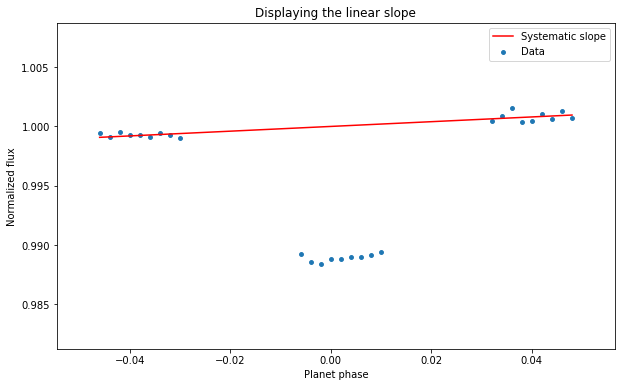

In [33]:
# Create linear slope
m_fac = 0.02
slope = (data_x * m_fac) + 1.00

plt.figure(figsize=(10, 6))
plt.title('Displaying the linear slope')
plt.scatter(data_x, data_y, s=15, label='Data')
plt.plot(data_x, slope, c='r', label='Systematic slope')
plt.xlabel('Planet phase')
plt.ylabel('Normalized flux')
plt.legend()

To conclude all of this, we can display our best model fit. Since the best fit is the last one that was performed in the fitting loop further above, we can use directly that, note however how we set `m_fac` to zero because we want the smooth model to not include the instrumental slope.

We overplot the original data with the fitted data and the fitted smooth model in order to see what it all looks like:

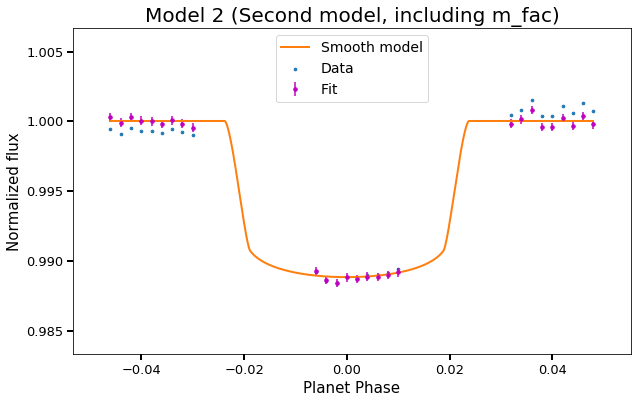

In [34]:
# We first need to recalculate the fit model on a smoother grid though,
# in the same way we did further above.
# Dump parameters in a single tuple again - note that we set m_fac to zero 
params_result_m1 = (marg_model.rl.val, marg_model.flux0.val, marg_model.epoch.val, marg_model.inclin.val,
                    marg_model.MsMpR.val, marg_model.ecc.val, marg_model.omega.val, marg_model.period.val,
                    marg_model.tzero.val, marg_model.c1.val, marg_model.c2.val, marg_model.c3.val,
                    marg_model.c4.val, 0., marg_model.hstp1.val, marg_model.hstp2.val,
                    marg_model.hstp3.val, marg_model.hstp4.val, marg_model.xshift1.val,
                    marg_model.xshift2.val, marg_model.xshift3.val, marg_model.xshift4.val)

# Recalculate model on smooth grid now that we performed the fit
flux1_smooth = marg_model.calc(pars=params_result_m1, x=x_smooth)

plt.figure(figsize=(10, 6))
plt.scatter(data_x, data_y, s=7, label='Data')
plt.plot(x_smooth, flux1_smooth, c='#ff7f0e', lw=2, label='Smooth model')
plt.errorbar(data_x, sys_flux[1], yerr=data.staterror, fmt='m.', markersize=7, label='Fit')
plt.title('Model 2 (Second model, including m_fac)', size=20)
plt.xlabel('Planet Phase', size=15)
plt.ylabel('Normalized flux', size=15)
plt.tick_params(axis='both', which='both', length=6, width=2, labelsize=13)
plt.legend(loc='upper center', prop={'size': 14})
plt.show()

We can clearly see how the purple points of the fit data have been put onto a more vertical orientation than the original data, which is due to the integration of the slope parameter `m_fac` into the systematics.

## Full marginalisation

To launch the full marginalisation over all systematic models on a data set on disk, **run `marginalisation.py`**. This script first performs a fit on all systematic models to scale the uncertainties to unity chi-squared, then it fits all systematic models again and saves the fit parameters for each of them. In a final step, the marginalisation over all stsyematic models is performed, plotted and saved to `[data_paths] -> output_path`.

The reson we fit all models twice is the error estimation. The input flux errors are pure photon noise, which does not incorporate all information on real noise sources. The first fit is intended to understant additional noise sources. This is done by rescaling all uncertainties so that the data and the model have a reduced chi-squared of one. This means that the uncertainties will get slightly larger than pur photon noise and we use these more conservative (and probably more accurate) errors when running the second round of fitting, yielding fit parameters that we can trust better.

This two-part fit setup will probably be revisited in the near future.